In [3]:
import ee
import geemap
import time
import requests
import json
import os
from geemap import geojson_to_ee, ee_to_geojson
from ipyleaflet import GeoJSON
import geopandas as gpd
import topojson as tp
from shapely.geometry import Polygon
import pandas as pd

In [4]:
ee.Initialize()
Map = geemap.Map()

In [5]:
def fire_boundary(i):
    Temporada=int('{}'.format(i)) # temporada 2017 inicia en Julio 2016 y terminia en agosto 2017
    countries = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')
    roi = countries.filterMetadata('country_na', 'equals', 'Chile')

    t1 = str(Temporada-1) +'-08-01'
    t2 = str(Temporada) +'-08-01'

    fire_boundary = ee.FeatureCollection('JRC/GWIS/GlobFire/v2/FinalPerimeters')\
        .filterMetadata('FDate', 'greater_than', ee.Date(t1).millis())\
        .filterMetadata('FDate', 'less_than', ee.Date(t2).millis())\
        .filterBounds(roi)
    fire = geemap.ee_to_geopandas(fire_boundary)#.drop(0)
    fire['FechaInicio']=pd.to_datetime(fire['IDate'],unit='ms')
    fire['FechaFin']=pd.to_datetime(fire['FDate'],unit='ms')
    # remove the IDate and Fdate column
    fire.drop(['IDate','FDate'], axis=1, inplace=True)
    perimetro="data/r20_mcd64a1_"+str(Temporada)+".json"
    if os.path.exists(perimetro):
        os.remove(perimetro)
    fire.to_file(perimetro, driver="GeoJSON")
    return perimetro

In [6]:
fire=fire_boundary(2017)

In [11]:
# Read file
gdf = gpd.read_file(fire)

# Sort the GeoDataFrame in descending order by the polygon's area
gdf 


,Id,FechaInicio,FechaFin,geometry
0,20109883,2016-10-17T00:00:00,2017-03-12T00:00:00,"POLYGON ((-180.00000 -90.00000, 180.00000 -90...."
1,19673299,2016-07-30T23:59:56.928001,2016-08-06T00:00:00,"MULTIPOLYGON (((-71.29754 -34.67083, -71.30112..."
2,20497683,2017-03-07T00:00:00,2017-03-22T00:00:00,"POLYGON ((-72.19464 -38.34583, -72.19048 -38.3..."
3,20497682,2017-03-07T00:00:00,2017-03-10T00:00:00,"POLYGON ((-72.27411 -38.30833, -72.27826 -38.3..."
4,20497587,2017-03-07T00:00:00,2017-03-09T00:00:00,"MULTIPOLYGON (((-71.88094 -34.12500, -71.87032..."
...,...,...,...,...
483,20635073,2017-05-27T00:00:00,2017-05-31T00:00:00,"MULTIPOLYGON (((-70.60707 -32.07500, -70.61029..."
484,20635076,2017-05-27T00:00:00,2017-05-31T00:00:00,"MULTIPOLYGON (((-70.64299 -32.21667, -70.64623..."
485,20160630,2016-11-20T00:00:00,2016-11-20T00:00:00,"POLYGON ((-72.12920 -46.99583, -72.13483 -47.0..."
486,20054337,2016-10-11T00:00:00,2016-10-11T00:00:00,"POLYGON ((-70.79151 -32.98750, -70.79485 -32.9..."


<AxesSubplot:>

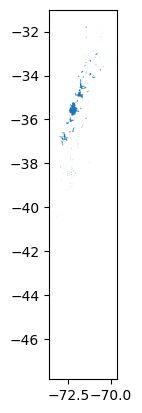

In [13]:
gdf['area']=gdf.geometry.area

df = gdf.sort_values('area', ascending=False)

# Drop the largest polygon
df = df.iloc[1:]


In [17]:
df.head()

,Id,FechaInicio,FechaFin,geometry,area
117,20334710,2017-01-18T00:00:00,2017-02-05T00:00:02.048000,"MULTIPOLYGON (((-71.92002 -35.65000, -71.92377...",0.171321
303,20334783,2017-01-20T00:00:00,2017-02-06T00:00:00,"MULTIPOLYGON (((-72.80232 -36.61250, -72.80625...",0.056137
393,20334692,2017-01-15T00:00:00,2017-02-03T00:00:00,"MULTIPOLYGON (((-71.92883 -34.80833, -71.93391...",0.055341
214,20334677,2017-01-13T00:00:00,2017-01-29T00:00:00,"MULTIPOLYGON (((-71.60278 -34.56667, -71.60637...",0.042468
224,20334747,2017-01-16T00:00:00,2017-02-01T00:00:00,"MULTIPOLYGON (((-72.30848 -36.02083, -72.31363...",0.022110


In [21]:
datetime.strdf['FechaInicio']

117    2017-01-18T00:00:00
303    2017-01-20T00:00:00
393    2017-01-15T00:00:00
214    2017-01-13T00:00:00
224    2017-01-16T00:00:00
              ...         
457    2016-10-25T00:00:00
481    2017-05-27T00:00:00
453    2017-05-29T00:00:00
452    2017-05-29T00:00:00
479    2017-05-27T00:00:00
Name: FechaInicio, Length: 487, dtype: object

In [57]:
# for i in list(range(2000,2023)):
#     fire_boundary(i)